In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.data_utils import (
    test_missing_bias,
    get_missing_data_summary,
    missing_by_dataset,
    missing_by_outcome,
    handle_impossible_zeros,
    impute_missing_values,
)

from src.utils.data_utils import drop_id
from src.utils.graph_utils import(
    display_relative_histoplot,
    display_histoplot,
    display_multi_histoplot,
    display_multi_boxplot,
    display_categorical_plots,
    display_boxplot,
    display_scatterplot
) 
from src.utils.notebook_setup import setup_notebook_environment

# Quick setup
dbs, logger = await setup_notebook_environment()

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Now ready to work
logger.info("Starting data preprocessing...")

# Checking Bronze Layer
bronze_data = await dbs.get_bronze_data()
bronze_data_df = pd.DataFrame(bronze_data)
bronze_data_df.head(10)

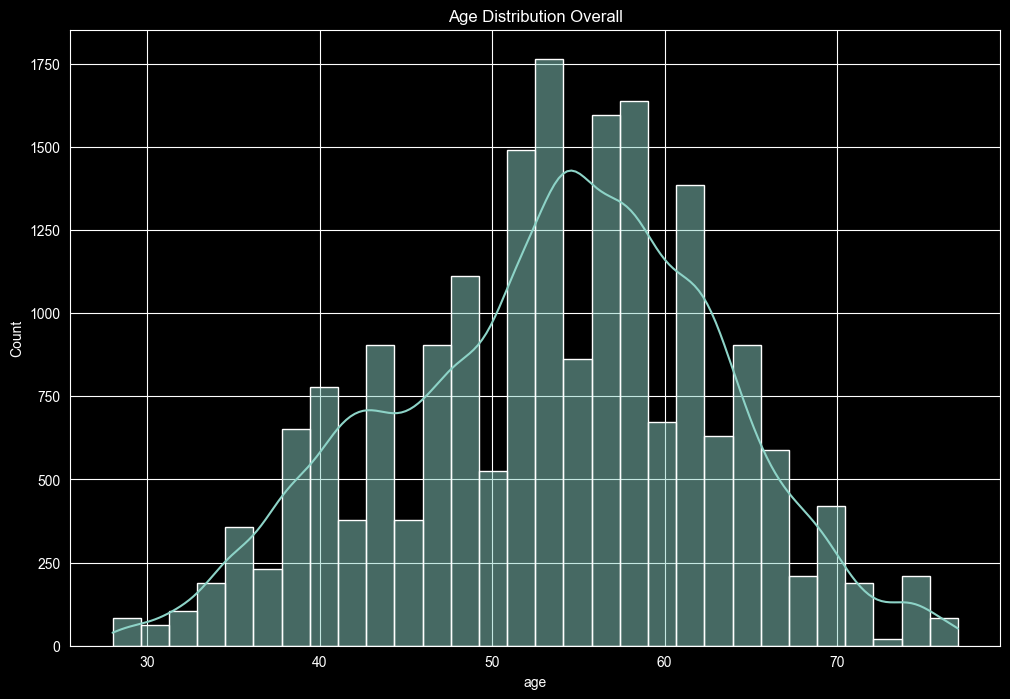

2025-07-25 11:03:16,618 - src.utils.notebook_setup - INFO - Mean: 53.51
2025-07-25 11:03:16,623 - src.utils.notebook_setup - INFO - Median: 54.00
2025-07-25 11:03:16,628 - src.utils.notebook_setup - INFO - Mode: 54.00


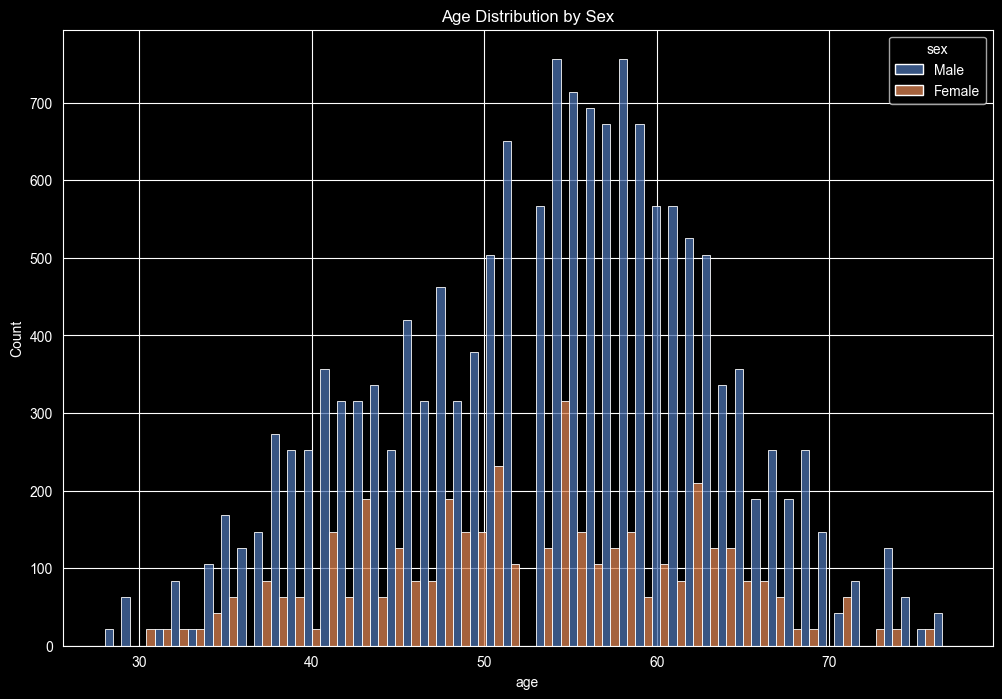

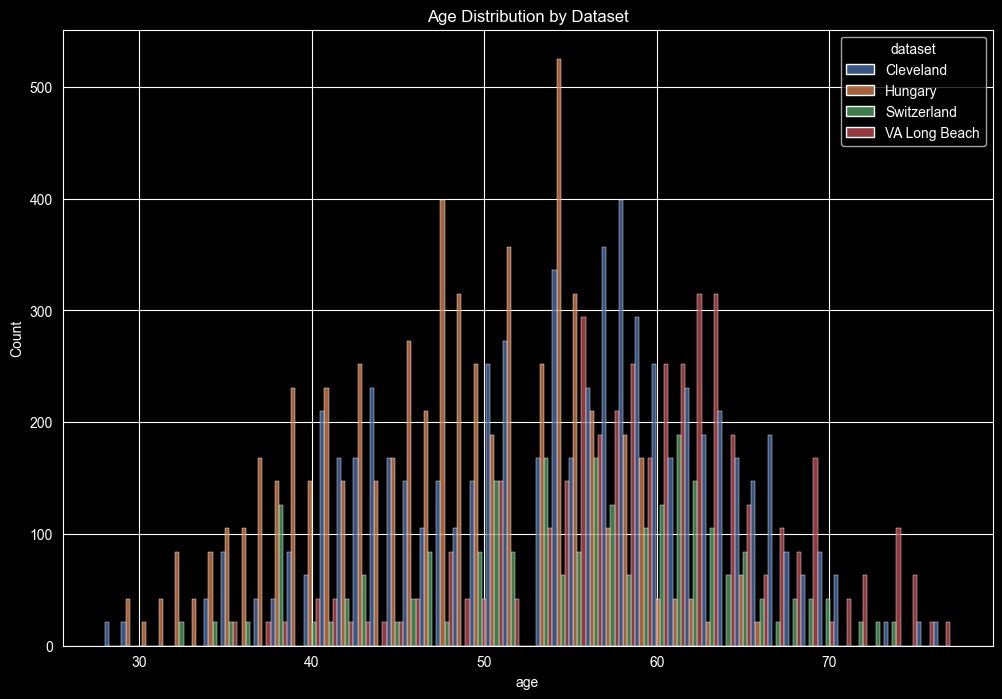

In [15]:


display_histoplot(df=bronze_data_df, column_name='age', title='Age Distribution Overall')
logger.info(f"Mean: {bronze_data_df['age'].mean():.2f}")
logger.info(f"Median: {bronze_data_df['age'].median():.2f}")
logger.info(f"Mode: {bronze_data_df['age'].mode()[0]:.2f}")

display_relative_histoplot(df=bronze_data_df, x_column_name='age', hue_column_name='sex', title='Age Distribution by Sex')
bronze_data_df['sex'].value_counts()

# see age distribution by dataset
display_relative_histoplot(bronze_data_df, 'age', 'dataset', 'Age Distribution by Dataset')

In [16]:
# Identify Duplicates
bronze_data_df.duplicated().sum()

if bronze_data_df.duplicated().sum() > 0:
    bronze_data_df = bronze_data_df.drop_duplicates()
    logger.info("Dropped duplicate rows")
else:
    logger.info("No duplicate rows found")

# checking data info
bronze_data_df.info()
logger.info(bronze_data_df.info())

# DROP COLUMNS
bronze_data_df = bronze_data_df.drop(columns=['_id', "id"])

# show dataframe
bronze_data_df.head()

2025-07-25 11:03:18,969 - src.utils.notebook_setup - INFO - No duplicate rows found
2025-07-25 11:03:19,012 - src.utils.notebook_setup - INFO - None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19320 entries, 0 to 19319
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   _id       19320 non-null  object 
 1   id        19320 non-null  int64  
 2   age       19320 non-null  int64  
 3   sex       19320 non-null  object 
 4   dataset   19320 non-null  object 
 5   cp        19320 non-null  object 
 6   trestbps  18081 non-null  float64
 7   chol      18690 non-null  float64
 8   fbs       17430 non-null  object 
 9   restecg   19278 non-null  object 
 10  thalch    18165 non-null  float64
 11  exang     18165 non-null  object 
 12  oldpeak   18018 non-null  float64
 13  slope     12831 non-null  object 
 14  ca        6489 non-null   float64
 15  thal      9114 non-null   object 
 16  num       19320 non-null  int64  
dtypes: float64(5), int64(3), object(9)
memory usage: 2.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19320 entries, 0 to 19319
Data columns

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


2025-07-25 11:03:19,059 - src.utils.notebook_setup - INFO - Unique value COUNT in categorical columns
2025-07-25 11:03:19,124 - src.utils.notebook_setup - INFO - sex        2
dataset    4
cp         4
fbs        2
restecg    3
exang      2
slope      3
thal       3
dtype: int64
2025-07-25 11:03:19,126 - src.utils.notebook_setup - INFO - Unique values in categorical columns
2025-07-25 11:03:19,128 - src.utils.notebook_setup - INFO - ca: [0. 3. 2. 1.]
2025-07-25 11:03:19,133 - src.utils.notebook_setup - INFO - thal: ['fixed defect' 'normal' 'reversable defect']
2025-07-25 11:03:19,141 - src.utils.notebook_setup - INFO - slope: ['downsloping' 'flat' 'upsloping']
2025-07-25 11:03:19,142 - src.utils.notebook_setup - INFO - Unique values COUNT in numerical columns
2025-07-25 11:03:19,149 - src.utils.notebook_setup - INFO - age          50
trestbps     61
chol        217
thalch      119
oldpeak      53
ca            4
num           5
dtype: int64
2025-07-25 11:03:19,153 - src.utils.notebook_s

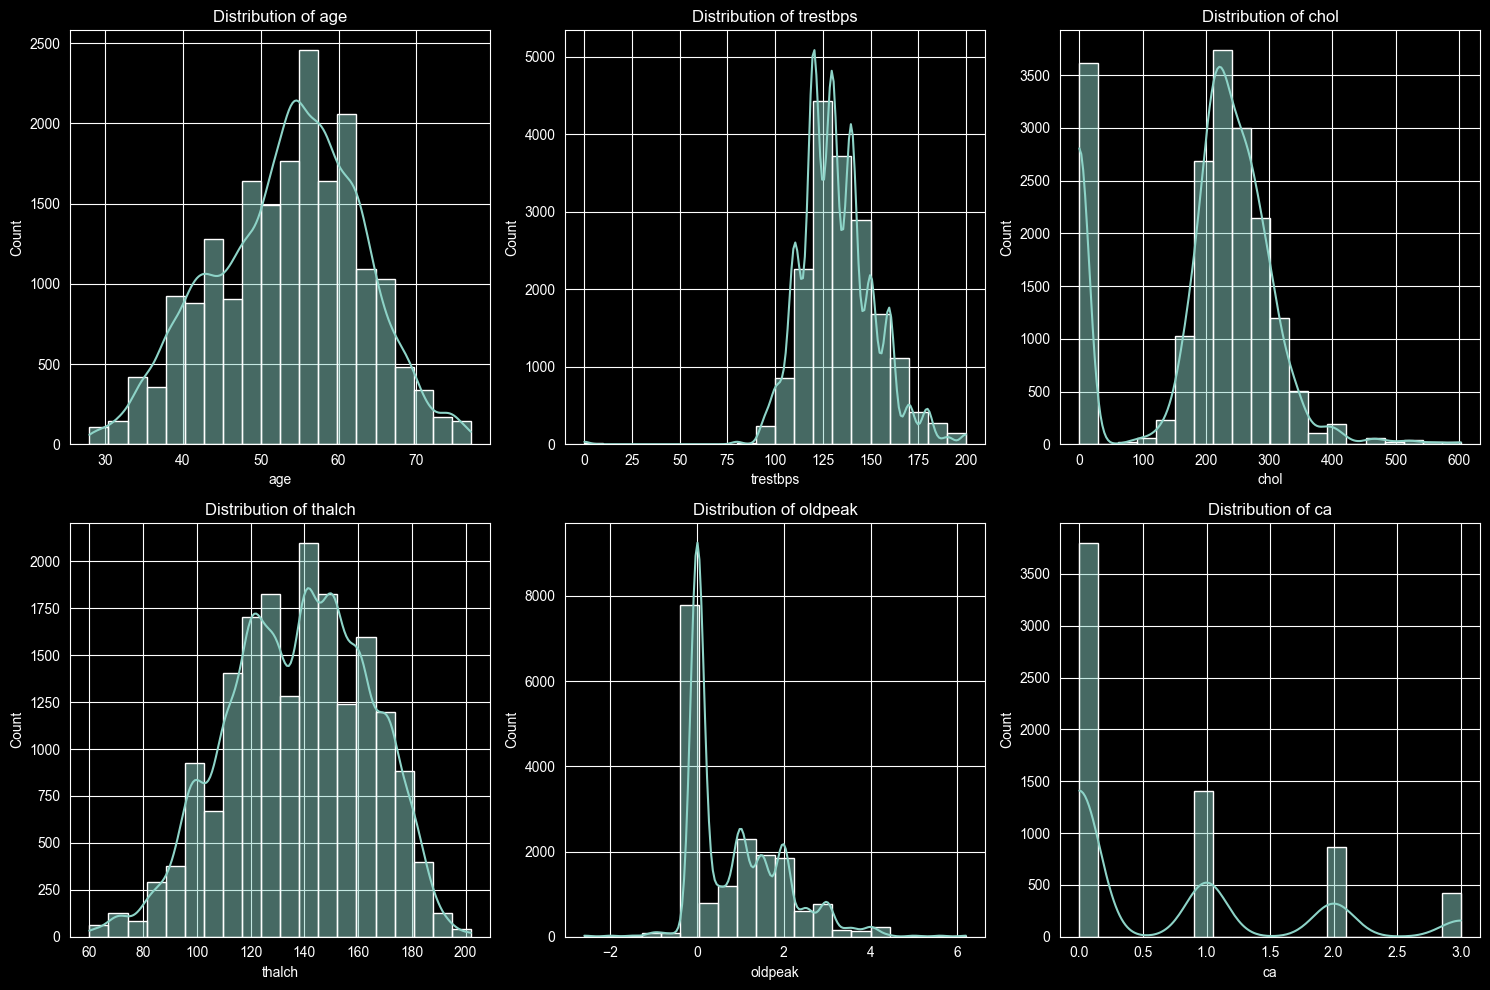

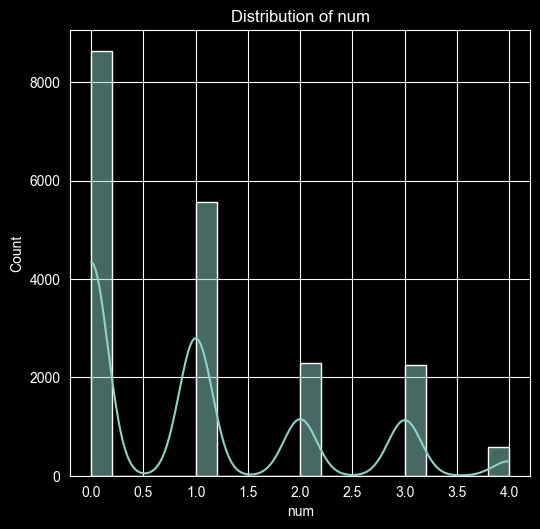

2025-07-25 11:03:23,135 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-25 11:03:23,159 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-25 11:03:23,247 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-25 11:03:23,375 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-25 11:03:23,

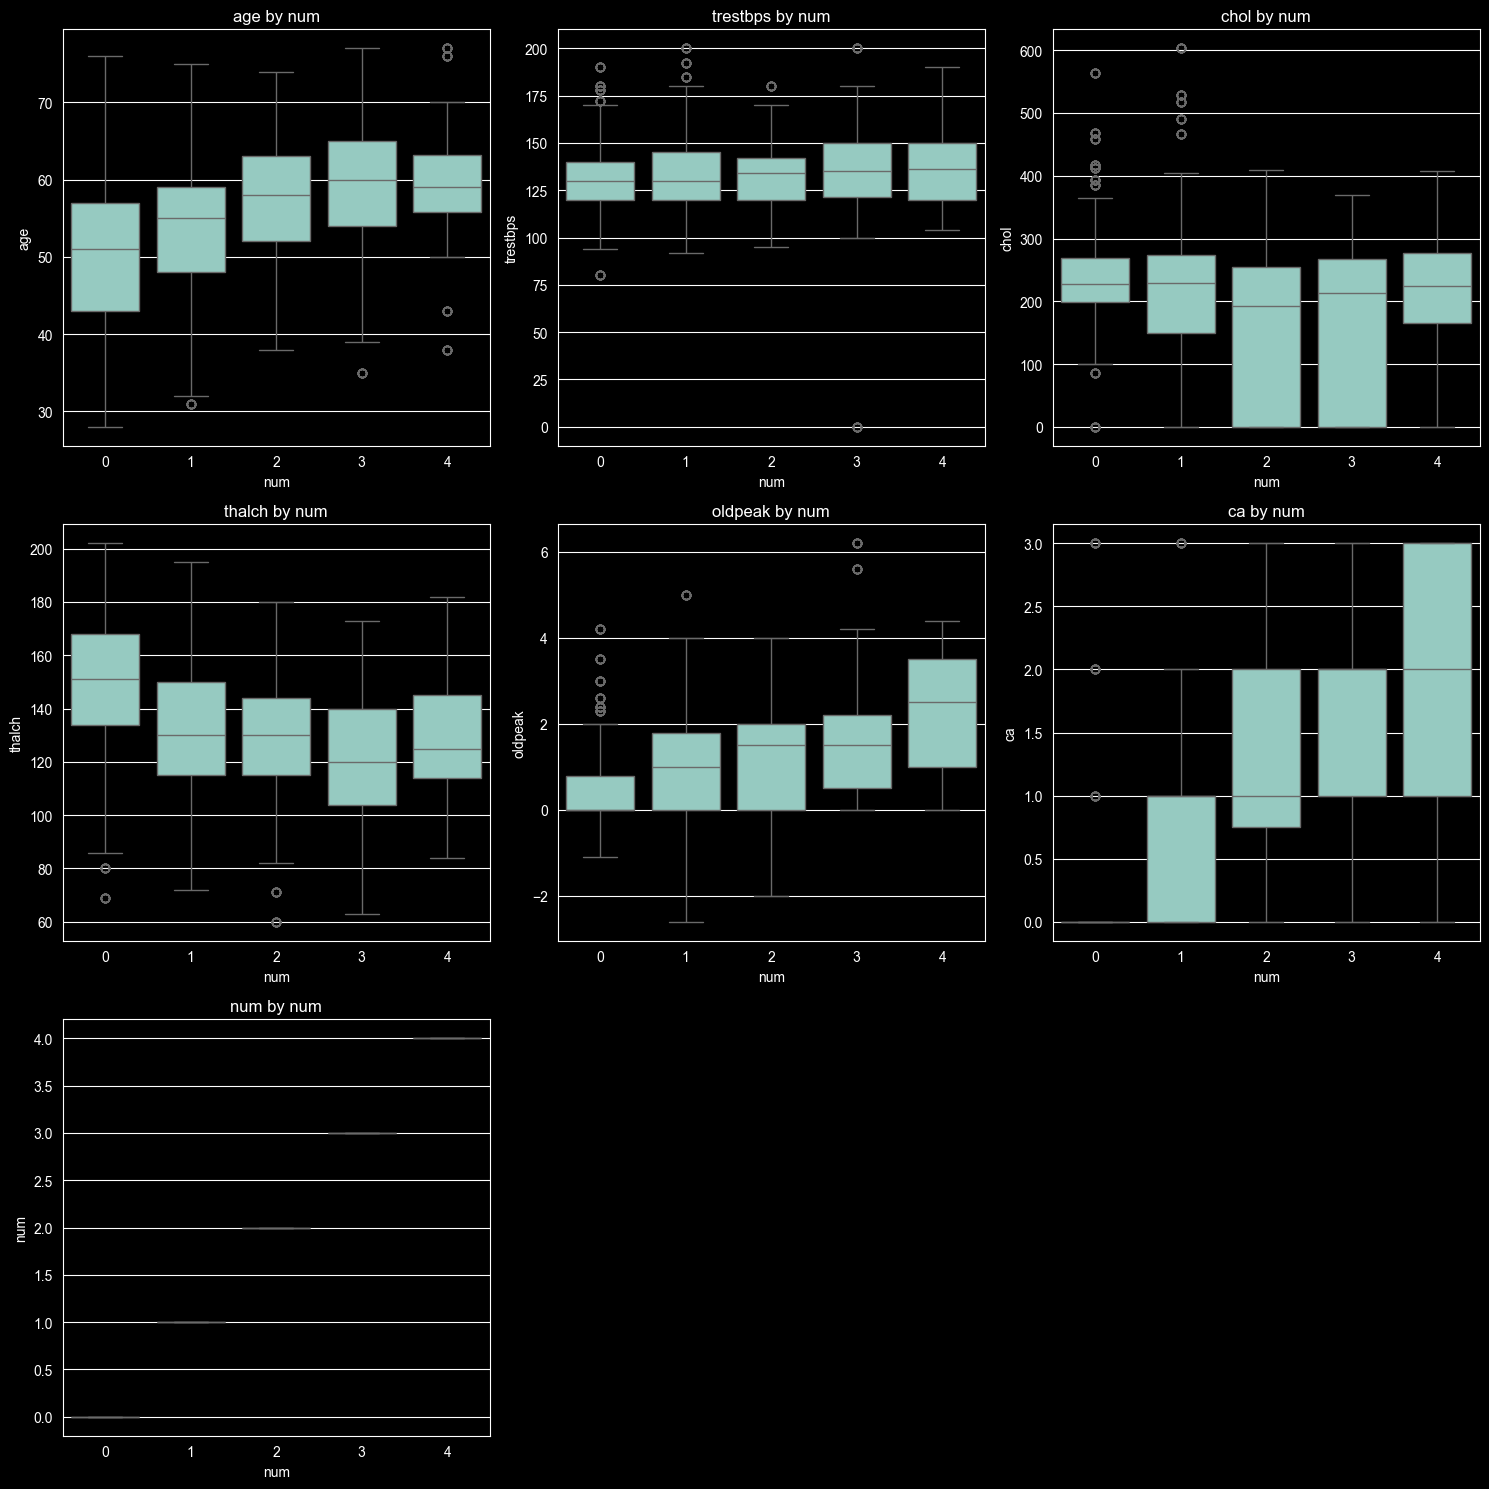

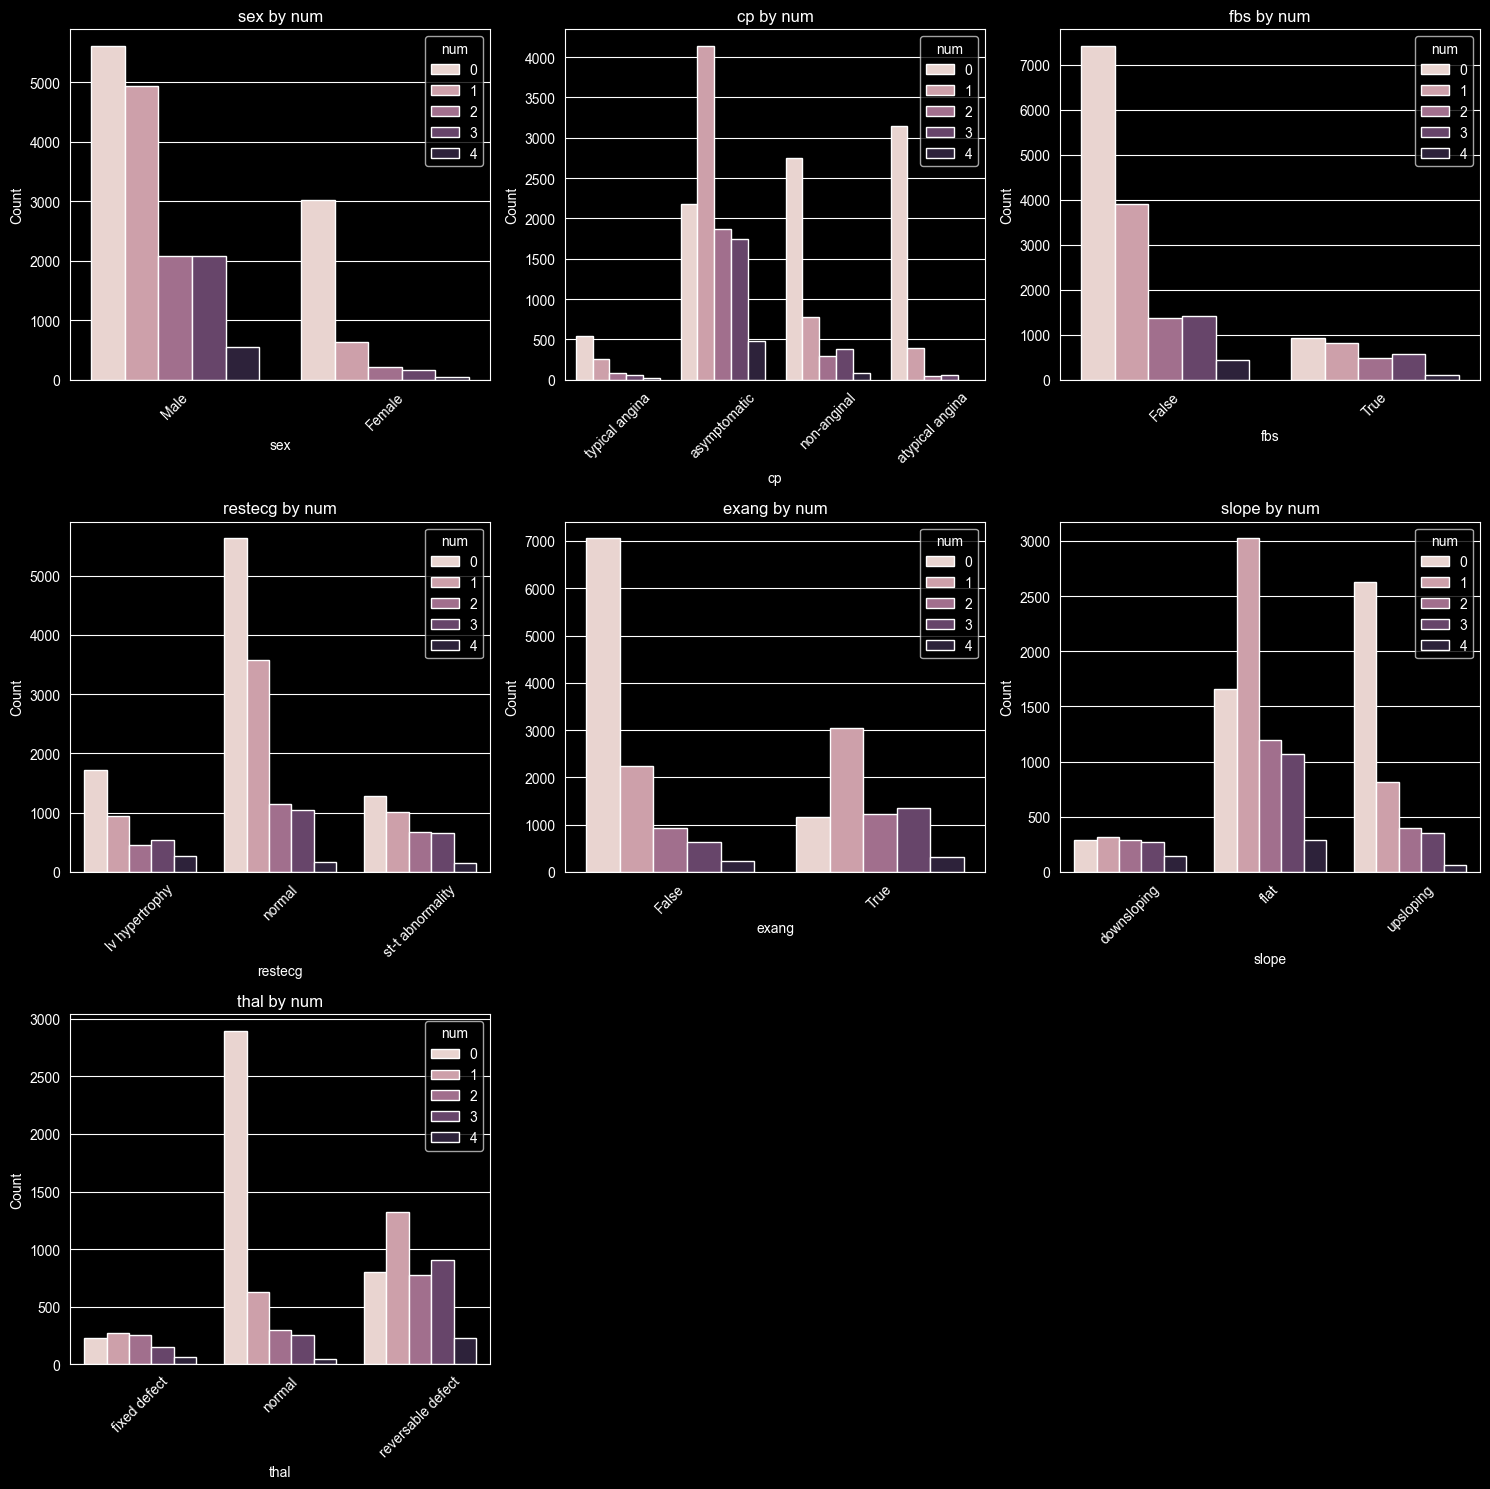

In [17]:
# Checing Categorical Columns
cat_cols = bronze_data_df.select_dtypes(include=['object']).columns
num_cols = bronze_data_df.select_dtypes(include=['int64', 'float64']).columns

# Check unique values in categorical columns
logger.info("Unique value COUNT in categorical columns")
logger.info(bronze_data_df[cat_cols].nunique())

logger.info("Unique values in categorical columns")
logger.info(f"ca: {bronze_data_df['ca'].unique()[:bronze_data_df['ca'].nunique()]}")
logger.info(f"thal: {bronze_data_df['thal'].unique()[:bronze_data_df['thal'].nunique()]}")
logger.info(f"slope: {bronze_data_df['slope'].unique()[:bronze_data_df['slope'].nunique()]}")

# Check numerical columns
logger.info("Unique values COUNT in numerical columns")
logger.info(bronze_data_df[num_cols].nunique())
# Remove non-plotting columns
cat_cols = [col for col in cat_cols if col not in ['_id', 'dataset']]
num_cols = [col for col in num_cols if col not in ['id']]

logger.info("Unique value COUNT in categorical columns")
logger.info(bronze_data_df[cat_cols].nunique())

# Visualize Numerical Columns (histograms)
if len(num_cols) > 6:
    display_multi_histoplot(bronze_data_df, num_cols[:6])
    if len(num_cols) > 6:
        display_multi_histoplot(bronze_data_df, num_cols[6:])
else:
    display_multi_histoplot(bronze_data_df, num_cols)

# Visualize Numerical Boxplots (fixed)
display_multi_boxplot(bronze_data_df, num_cols, target_col='num')

# Visualize Categorical Columns (use count plots instead)
display_categorical_plots(bronze_data_df, cat_cols, target_col='num')



In [18]:
missing_df = get_missing_data_summary(bronze_data_df)

missing_df.head(20)

,Column,Missing Count,Missing %,Severity
2,fbs,"1,890",9.8%,Low
8,ca,"12,831",66.4%,High
6,oldpeak,"1,302",6.7%,Low
0,trestbps,"1,239",6.4%,Low
4,thalch,"1,155",6.0%,Low
5,exang,"1,155",6.0%,Low
9,thal,"10,206",52.8%,High
7,slope,"6,489",33.6%,High
1,chol,630,3.3%,Low
3,restecg,42,0.2%,Low


In [19]:
# Running Tests Missing Data to Determine MNAR or MAR Missingness

# TRUE = Missing pattern correlates with heart disease outcome, most likely missing because of patient condition (sicker patients get more tests)

missing_bias_df = pd.DataFrame(columns=['Column', 'MNAR from Chi-square test'])
for col in bronze_data_df.columns:
    missing_bias_df.loc[len(missing_bias_df)] = [col, test_missing_bias(bronze_data_df, col, 'num')]

logger.info("Missing bias:")
missing_bias_df.head(20)

2025-07-25 11:03:29,673 - src.utils.notebook_setup - INFO - Missing bias:


,Column,MNAR from Chi-square test
0,age,False
1,sex,False
2,dataset,False
3,cp,False
4,trestbps,True
5,chol,True
6,fbs,True
7,restecg,True
8,thalch,True
9,exang,True


In [20]:
# Running Tests Missing Data to Determine MNAR or MAR Missing by Dataset

# TRUE = Different studies have different missing patterns, Different hospitals/studies had different protocols
missing_by_dataset_df = pd.DataFrame(columns=['Column', 'MNAR FROM DATASET ORIGIN'])
for col in bronze_data_df.columns:
    missing_by_dataset_df.loc[len(missing_by_dataset_df)] = [col, missing_by_dataset(bronze_data_df, col)]

logger.info("Missing by dataset:")
missing_by_dataset_df.head(20)

2025-07-25 11:03:29,952 - src.utils.notebook_setup - INFO - Missing by dataset:


,Column,MNAR FROM DATASET ORIGIN
0,age,False
1,sex,False
2,dataset,False
3,cp,False
4,trestbps,True
5,chol,False
6,fbs,True
7,restecg,False
8,thalch,True
9,exang,True


In [21]:
# Check missingness by outcome

missing_by_outcome_df = pd.DataFrame(columns=['Column', 'MNAR FROM OUTCOME'])
for col in bronze_data_df.columns:
    missing_by_outcome_df.loc[len(missing_by_outcome_df)] = [col, missing_by_outcome(bronze_data_df, col)]

logger.info("Missing by outcome:")
missing_by_outcome_df.head(20)

2025-07-25 11:03:30,108 - src.utils.notebook_setup - INFO - Missing by outcome:


,Column,MNAR FROM OUTCOME
0,age,False
1,sex,False
2,dataset,False
3,cp,False
4,trestbps,False
5,chol,False
6,fbs,True
7,restecg,False
8,thalch,False
9,exang,False


In [22]:
# Create binary target as required
bronze_data_df['target'] = (bronze_data_df['num'] > 0).astype(int)
# 0 = no heart disease, 1 = any heart disease

# Drop original multi-class target  
bronze_data_df = bronze_data_df.drop(columns=['num'])
bronze_data_df.head(20)


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,1
7,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0
8,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,1
9,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1


In [23]:
"""
Judging from the MNAR tests and the missing patterns, we can see that ca and thal values should be dropped
 - Medical knowledge confirms that 'ca' being fluoroscopy is an expensive and invasive test only order for most likely high risk paitents
 - Medical knowledge confirms that 'thal' being a stress test is only conducted when doctors suspect heart problems
 - TRUE across all tests indicated that Systematic, non-random missingness
 - 66.4% and 52.8% missing = Too much missing data
 - Missingness predicts outcome, so we should drop these columns

 Imputing with mean or mode would introdue bias!
"""

# Drop ca and thal columns
logger.info("Dropping ca and thal columns!")
if 'ca' in bronze_data_df.columns and 'thal' in bronze_data_df.columns:
    bronze_data_df = bronze_data_df.drop(columns=['ca', 'thal'])

logger.info(bronze_data_df.shape)
bronze_data_df.head()

2025-07-25 11:03:30,333 - src.utils.notebook_setup - INFO - Dropping ca and thal columns!
2025-07-25 11:03:30,343 - src.utils.notebook_setup - INFO - (19320, 13)


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,target
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0


In [24]:
"""
Slope is the slope of the peak exercise ST segment. It refers to the excercise stress test and when its administered it can be a valuable test
Now for the slope column ... there was about 33% missing data meaning that 66% of the data was complete. 

Stress test can be a valuable test, but it is not always administered. But even when its not administered, it can be an indicator that it was Not needed

So Since 
"""

# Create a new column for missing slope values
bronze_data_df['slope'] = bronze_data_df['slope'].fillna('not_tested')
logger.info(bronze_data_df.shape)
bronze_data_df.head()


# Find missing values again
missing_values = get_missing_data_summary(bronze_data_df)
logger.info("Missing values after handling slope missing values")
missing_values.head(20)

2025-07-25 11:03:30,376 - src.utils.notebook_setup - INFO - (19320, 13)
2025-07-25 11:03:30,403 - src.utils.notebook_setup - INFO - Missing values after handling slope missing values


,Column,Missing Count,Missing %,Severity
2,fbs,"1,890",9.8%,Low
6,oldpeak,"1,302",6.7%,Low
0,trestbps,"1,239",6.4%,Low
4,thalch,"1,155",6.0%,Low
5,exang,"1,155",6.0%,Low
1,chol,630,3.3%,Low
3,restecg,42,0.2%,Low


In [25]:


# 1. Handle impossible zeros
cleaned_df = handle_impossible_zeros(bronze_data_df)

# 2. Impute all missing values (including new NaNs from zeros)
imputed_df = impute_missing_values(cleaned_df)

# 3. Verify no missing values remain : summing the null counts across all columns
assert imputed_df.isnull().sum().sum() == 0, "Still have missing values!"


2025-07-25 11:03:30,433 - src.utils.data_utils - INFO - chol: Replaced 3612 impossible zeros with NaN
2025-07-25 11:03:30,437 - src.utils.data_utils - INFO - trestbps: Replaced 21 impossible zeros with NaN
2025-07-25 11:03:30,440 - src.utils.data_utils - INFO - thalch: Replaced 0 impossible zeros with NaN
2025-07-25 11:03:30,443 - src.utils.data_utils - INFO - age: Replaced 0 impossible zeros with NaN
2025-07-25 11:03:30,481 - src.utils.data_utils - INFO - chol: Imputed 4242 missing values with median 239.5
2025-07-25 11:03:30,484 - src.utils.data_utils - INFO - trestbps: Imputed 1260 missing values with median 130.0
2025-07-25 11:03:30,487 - src.utils.data_utils - INFO - thalch: Imputed 1155 missing values with median 140.0
2025-07-25 11:03:30,491 - src.utils.data_utils - INFO - oldpeak: Imputed 1302 missing values with median 0.5
2025-07-25 11:03:30,498 - src.utils.data_utils - INFO - fbs: Imputed 1890 missing values with mode 'False'
2025-07-25 11:03:30,505 - src.utils.data_utils - 

In [26]:

# Final Step: Save cleaned data to Silver layer

# Verify final data quality
logger.info("=" * 60)
logger.info("FINAL SILVER LAYER DATA SUMMARY")
logger.info("=" * 60)

logger.info(f"Final dataset shape: {imputed_df.shape}")
logger.info(f"Missing values remaining: {imputed_df.isnull().sum().sum()}")
logger.info(f"Target variable distribution:\n{imputed_df['target'].value_counts()}")

# Show final columns
logger.info(f"Final columns: {list(imputed_df.columns)}")

# Save to Silver collection in MongoDB
logger.info("Saving cleaned data to Silver layer...")

# Convert DataFrame to records for MongoDB
silver_data = imputed_df.to_dict('records')

# Insert into Silver collection
success = await dbs.insert_silver_data(silver_data)

if success:
    logger.info(f"Successfully saved {len(silver_data)} records to Silver layer")
    
    # Verify the save
    silver_count = await dbs.get_collection_count('silver')
    logger.info(f"Silver collection now contains: {silver_count} documents")
    
    # Show sample of Silver data
    sample_silver = await dbs.get_sample_records('silver', count=3)
    logger.info("Sample Silver layer records:")
    for i, record in enumerate(sample_silver):
        logger.info(f"Record {i+1}: {record}")
        
else:
    logger.error("Failed to save data to Silver layer")

logger.info("Data preprocessing complete! Ready for feature engineering.")

2025-07-25 11:03:30,547 - src.utils.notebook_setup - INFO - ============================================================
2025-07-25 11:03:30,549 - src.utils.notebook_setup - INFO - FINAL SILVER LAYER DATA SUMMARY
2025-07-25 11:03:30,550 - src.utils.notebook_setup - INFO - ============================================================
2025-07-25 11:03:30,551 - src.utils.notebook_setup - INFO - Final dataset shape: (19320, 13)
2025-07-25 11:03:30,564 - src.utils.notebook_setup - INFO - Missing values remaining: 0
2025-07-25 11:03:30,566 - src.utils.notebook_setup - INFO - Target variable distribution:
target
1    10689
0     8631
Name: count, dtype: int64
2025-07-25 11:03:30,567 - src.utils.notebook_setup - INFO - Final columns: ['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'target']
2025-07-25 11:03:30,569 - src.utils.notebook_setup - INFO - Saving cleaned data to Silver layer...
2025-07-25 11:03:39,486 - api.services.database